<a href="https://colab.research.google.com/github/calvr/openDays2023-ma/blob/main/openDays_workshop2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop OpenDays 2023: Modelling & Analytics

##Calculate Wind Turbine wakes interaction using pywake

The objectives of this part are:

* Demonstrate an open-source python package - PyWake (https://topfarm.pages.windenergy.dtu.dk/PyWake/index.html) and its applicability via a simplified case.
* Understand how to model a wind farm interaction given a climate and a wind turbine model.
* Show the importance of taking the wake effects into consideration when modelling/designing a wind turbine park.

In this tutorial, the basic capabilities of PyWake are shown. Essentially, how to calculate a wind farm's AEP using the wind farm simulation tool and how to visualize and interpret the results. In addition, the use of flow maps is also shown.

**Install PyWake if needed**

In [1]:
#@title
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to /tmp/pip-req-build-7ki_5fq5
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git /tmp/pip-req-build-7ki_5fq5
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git to commit c48603bd28512fdc6aa031987b119990869cdab3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 82.2 MB/s eta 0:00:00
  Created wheel for py-wake: filename=py_wake-2.5.0-py3-none-any.whl size=58395795 sha256=fc1e4b1c7c094f9056c0a5c59f2ae1e067c4cd9baf881ad12985f19a68ffc73e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mezxiebq/wheels/eb/a5/d1/e7380004c5b927c92dd3bfb3a466983ecefc2e7119756db77d
Successfully built py-wake


#### Import and set up of wind turbines, site, and flow model

Here we will create our site object. For simplicity purposes we will define a site with an uniform spatial weibull.

Regarding to the climate, we define the same climate statistics for each wind direction.

In [2]:
from py_wake.site import UniformWeibullSite

#specifying the necessary parameters for the UniformWeibullSite object
site = UniformWeibullSite(p_wd = [1/12]*12, # sector frequencies
                          a = [9]*12,       # Weibull scale parameter
                          k = [2.4]*12,     # Weibull shape parameter
                          ti = 0.1          # turbulence intensity, optional
                         )

The wind turbine used for the simulation will be a Vestas V80. Alternatively we can create our custom wind turbine with the intended characteristics.

Defining our own wind turbine now:

****Wind turbine specifications****

Power and Thrust coefficient (Ct) curves:


[<Axes: title={'center': 'MyWT'}, xlabel='Wind speed [m/s]', ylabel='Power [W]'>,
 <Axes: ylabel='Thrust coefficient'>]

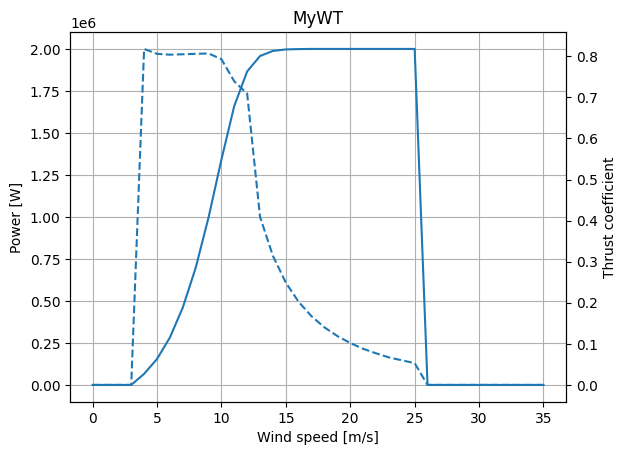

In [3]:
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import numpy as np

wsV80 = np.arange(0, 36, 1)
powerV80 = np.array([   0,    0,    0,    0,   66,  154,  282,  460,  696,  996, 1341,
                     1661, 1866, 1958, 1988, 1997, 1999, 2000, 2000, 2000, 2000, 2000,
                     2000, 2000, 2000, 2000,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0])
ctV80 = np.array([0.   , 0.   , 0.   , 0.   , 0.818, 0.806, 0.804, 0.805, 0.806,
                  0.807, 0.793, 0.739, 0.709, 0.409, 0.314, 0.249, 0.202, 0.167,
                  0.14 , 0.119, 0.102, 0.088, 0.077, 0.067, 0.06 , 0.053, 0.   ,
                  0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.])
rhoV80 = 1.225
diameter = 80


my_wt = WindTurbine(name='MyWT',
                    diameter=diameter,
                    hub_height=100,
                    rho = rhoV80,
                    powerCtFunction=PowerCtTabular(wsV80,powerV80,'kW',ctV80))


print('****Wind turbine specifications****\n')
print("Power and Thrust coefficient (Ct) curves:")
my_wt.plot_power_ct(ws=wsV80)

Now we are going to import the deficit models to use. 
There is a multitude of wind farm models, which can be combined in multiple ways. If you want to dive into it you can take a look in https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/EngineeringWindFarmModels.html.

In [4]:
from py_wake import NOJ

#here we import the wake deficit model
noj = NOJ(site,my_wt)

One of the most used is the PropagateDownwind which is very fast as it only performs a minimum of deficit calculations. It iterates over all turbines in downstream order. In each iteration it calculates the effective wind speed at the current wind turbine as the free stream wind speed minus the sum of the deficit from upstream sources. Based on this effective wind speed, it calculates the deficit caused by the current turbine on all downstream destinations. Note, that this procedure neglects upstream blockage effects.

The proceedure is illustrated in the animation below:

- **Iteration 1:** WT0 sees the free wind (10m/s). Its deficit on WT1 and WT2 is calculated.
- **Iteration 2:** WT1 sees the free wind minus the deficit from WT0. Its deficit on WT2 is calculated and the effective wind speed at WT2 is updated.

Open this link to see an animation of the PropagateDownwind model:
https://github.com/DTUWindEnergy/PyWake/blob/master/docs/_static/PropagateDownwind.gif?raw=1

**Now we run the model using the initial positions of the wind farm**

For more information about the `SimulationResult` object and the paratemers included, please see the [wind farm simulation](./RunWindFarmSimulation.ipynb) example.

In [5]:
import numpy as np

# number of turbines in each direction:
n_x = 5
n_y = 3

rotor_diameter = diameter
dist_x = 3 * rotor_diameter
dist_y = 3 * rotor_diameter

# This defines the turbine positions
wt_x, wt_y = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
wt_x = wt_x.flatten()
wt_y = wt_y.flatten()

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

In [6]:
n_wts = n_x * n_y

In [7]:
simulationResult = noj(wt_x,wt_y)

#### Overview of the results

To calculate the AEP, we use the **simulationResult.aep()** function. This will show an xarray with the characteristics of the site, including the number of turbines and the wind speed and wind direction studied. In addition, it will show the AEP of each turbine for each flow case.

In [8]:
simulationResult.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 15, wd: 360, ws: 23)>
array([[[0.00000000e+00, 6.17456424e-05, 1.28392862e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 6.17372180e-05, 1.28395659e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 6.17119279e-05, 1.28404053e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        ...,
        [0.00000000e+00, 6.16697221e-05, 1.28418054e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 6.17119279e-05, 1.28404053e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 6.17372180e-05, 1.28395659e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07]],

       [[0.00000000e+00, 6.17456424e-05, 1.28392862e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 6.17372180e-05, 1.28395659e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 6.17119279e-05, 1.28404053e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
...
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07]],

       [[0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        ...,
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07],
        [0.00000000e+00, 1.19062695e-04, 3.42946695e-04, ...,
         3.71528329e-06, 1.42587978e-06, 5.13590791e-07]]])
Coordinates:
  * wd       (wd) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int64 3 4 5 6 7 8 9 10 11 12 ... 16 17 18 19 20 21 22 23 24 25
  * wt       (wt) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    type     (wt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    Description:  Annual energy production [GWh]

To obtain the total AEP, we use the **.sum()** command.

In [9]:
print ("Total AEP: %f GWh"%simulationResult.aep().sum())

Total AEP: 91.109590 GWh


#### Plot AEP as a function of wind turbines, wind direction and wind speed

Text(0.5, 1.0, 'AEP vs wind direction')

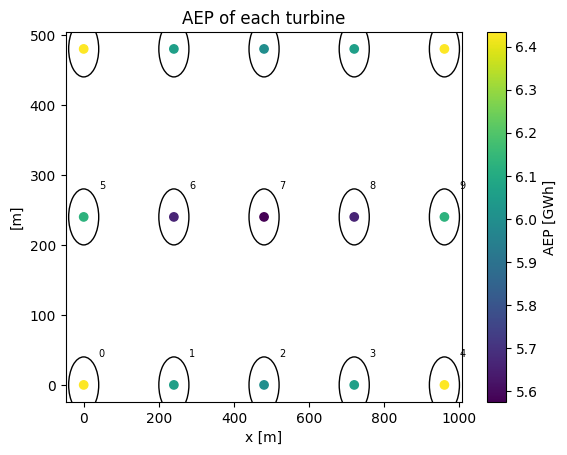

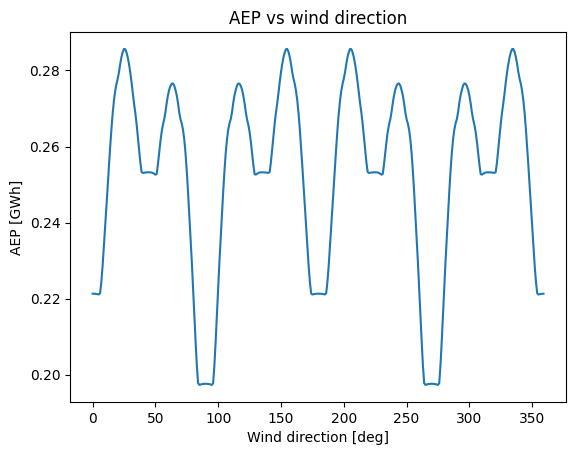

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
aep = simulationResult.aep() 
my_wt.plot(wt_x,wt_y)
c =plt.scatter(wt_x, wt_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

#### Plot flow maps

It is also possible to plot the wind farm wake map. This shows the wake behavior for each turbine given the flow cases studied.

You can change the values of the wind speed and wind direction to visualize the wake maps for different flow cases.

Text(0.5, 1.0, 'Wake map for 10 m/s and 270 deg')

<Figure size 640x480 with 0 Axes>

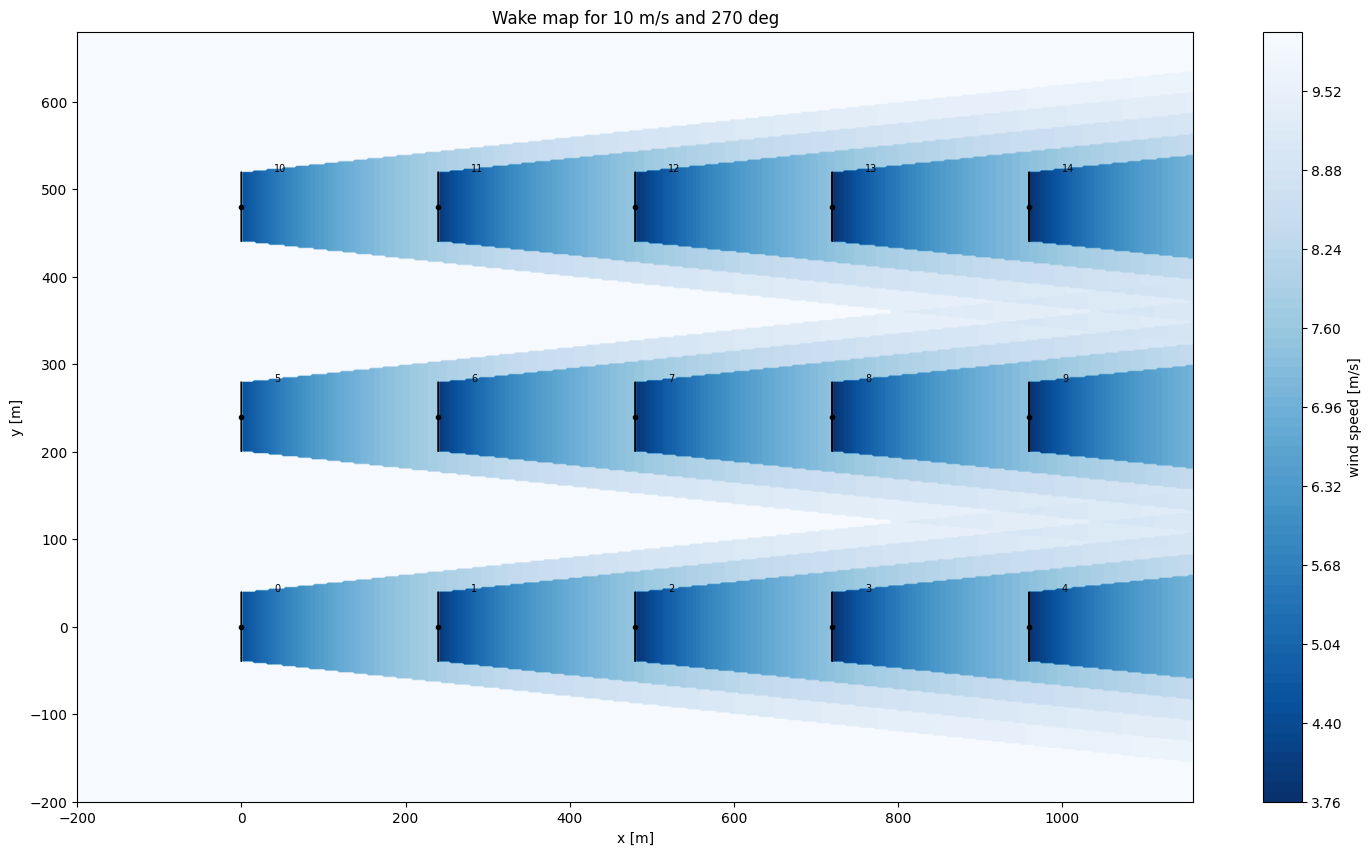

In [11]:
wind_speed = 10
wind_direction = 270

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

### Exercises

###1 - Calculate the following metrics based on the ***simulationResult*** object:

- Wake efficiency - AEP_waked/AEP
- Capacity factor - AEP/(park_rated_power * 8760)

Check the simulation result xarray dataset first to see what ouputs we got. 

In [12]:
simulationResult

<xarray.SimulationResult>
Dimensions:           (wt: 15, wd: 360, ws: 23)
Coordinates:
  * wd                (wd) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * ws                (ws) int64 3 4 5 6 7 8 9 10 11 ... 18 19 20 21 22 23 24 25
  * wt                (wt) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    type              (wt) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 3.0 3.519 3.874 ... 23.0 24.0 25.0
    TI_eff            (wt, wd, ws) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 0.0 3.423e+04 ... 2e+06 2e+06
    CT                (wt, wd, ws) float64 0.0 0.4242 0.7146 ... 0.06 0.053
    h                 (wt) int64 100 100 100 100 100 100 ... 100 100 100 100 100
    x                 (wt) int64 0 240 480 720 960 0 ... 960 0 240 480 720 960
    ...                ...
    ws_l              (ws) float64 2.5 3.5 4.5 5.5 6.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 3.5 4.5 5.5 6.5 7.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 9.0 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0 9.0
    Weibull_k         (wd) float64 2.4 2.4 2.4 2.4 2.4 ... 2.4 2.4 2.4 2.4 2.4
    Sector_frequency  (wd) float64 0.002778 0.002778 ... 0.002778 0.002778
    P                 (wd, ws) float64 0.000148 0.0002059 ... 2.931e-08

The following cell computes everything you need

In [13]:
AEP = simulationResult.aep().sum().values
AEP_unwaked = simulationResult.aep(with_wake_loss=False).sum().values

park_rated_power = powerV80.max() * n_wts

In [ ]:
# Complete this cell:
wake_eff = 
capacity_factor = 

Solution

In [14]:
#@title
# Solution:

wake_eff = AEP/AEP_unwaked
capacity_factor = AEP * 1E9/(park_rated_power * 1E3 * 8760)

Run the following cell to print the results

In [15]:
# When you have finished run this cell

print(f"""
Summary:
  - AEP: {AEP.round(2)} GWh
  - Wake efficiency: {wake_eff.round(2) * 100} [%]
  - Capacity factor: {capacity_factor.round(2) * 100} [%]
""")


Summary:
  - AEP: 91.11 GWh
  - Wake efficiency: 84.0 [%]
  - Capacity factor: 35.0 [%]



### 2 - Plot the wake efficiency as a function of the minimum distance between turbines:

Tip: Define the turbine position in a loop where you change the dist_x and dist_y parameters, and calculate the wake efficiency in each step.

In [ ]:
# Solve it here:


In [ ]:
#@title
# Solution:

dist_per_rd = np.arange(0.1,20, 0.5) 
dist = dist_per_rd * diameter
wake_eff = []

for distance in dist:
  # This defines the turbine positions
  wt_x_i, wt_y_i = np.meshgrid(np.array(range(n_x)) * distance, np.array(range(n_y)) * distance)
  wt_x_i = wt_x_i.flatten()
  wt_y_i = wt_y_i.flatten()
  sim_Res = noj(wt_x_i,wt_y_i)
  AEP =sim_Res.aep().sum().values
  AEP_unwaked = sim_Res.aep(with_wake_loss=False).sum().values

  wake_eff.append(AEP/AEP_unwaked * 100)

fig = plt.Figure()

plt.plot(dist_per_rd, wake_eff)
plt.xlabel('Distance / rotor diameter')
plt.ylabel('Wake efficiency [%]')
plt.show()


### 3 - Manually define the layout with the maximum amout of AEP

Requisites:

In [17]:
print(f"""
1 - It must be bounded to:
x ∈ [{x_min - 50}, {x_max + 50}] and y ∈ [{y_min -50 }, {y_max + 50}]
2 - You can not add more wind turbines
""")


1 - It must be bounded to:
x ∈ [-50, 1010] and y ∈ [-50, 530]
2 - You can not add more wind turbines



Later we will see if you were able to beat the optimizer... 😀

### Demonstration
Let's now consider now a more complex site.

This site considers orography caused speed-ups. The speed-ups can be defined as in the following Figure:


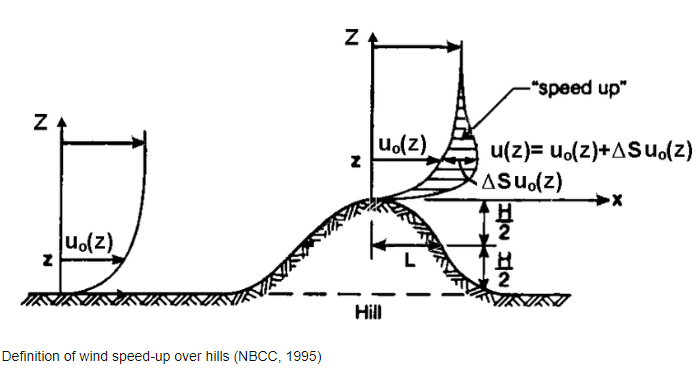

In [18]:
from py_wake.site import XRSite
import xarray as xr

f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

# Site with gridded speedup information
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.2, .002).reshape((20, 10))),
                   'P': ('wd', f), 'TI': ti},
        coords={'x': np.arange(0, 2000, 100), 'y': np.arange(0,1000,100), 'wd': wd}))


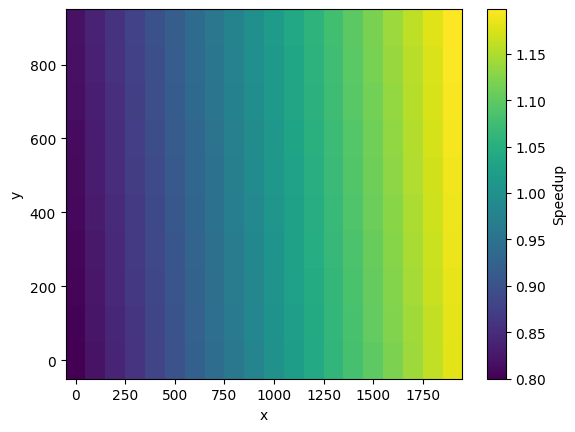

In [22]:
# Here we can visualize our speedups field:

complex_grid_site.ds.Speedup.plot()

<xarray.DataArray (sector: 12)>
array([0.03826667, 0.04038333, 0.05288333, 0.06976667, 0.0797    ,
       0.06926667, 0.0877    , 0.1188    , 0.14736667, 0.14131667,
       0.09908333, 0.05546667])
Coordinates:
  * sector   (sector) int64 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

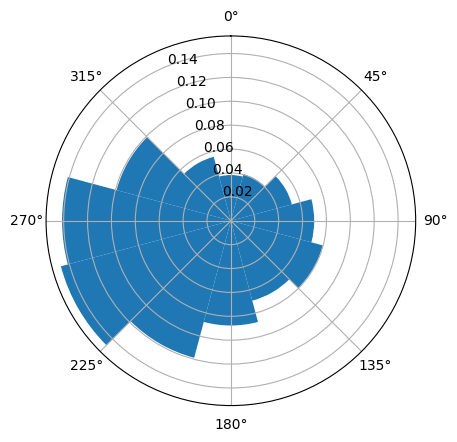

In [23]:
# And next we plot the wind rose
complex_grid_site.plot_wd_distribution()

Now we can run everything again but with this site object.

In [24]:
# Here we import the wake deficit model
noj = NOJ(complex_grid_site, my_wt)

simulationResult = noj(wt_x, wt_y)

Text(0.5, 1.0, 'AEP vs wind direction')

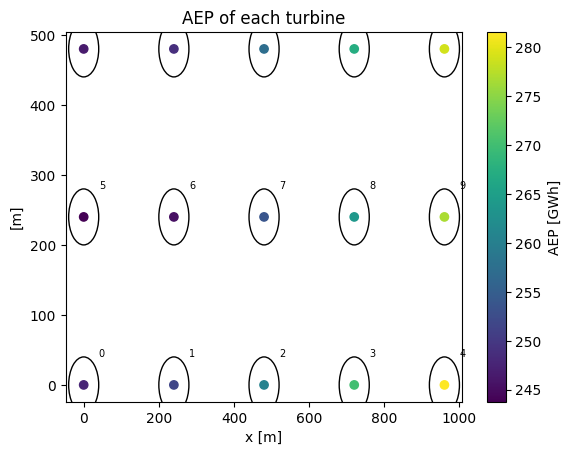

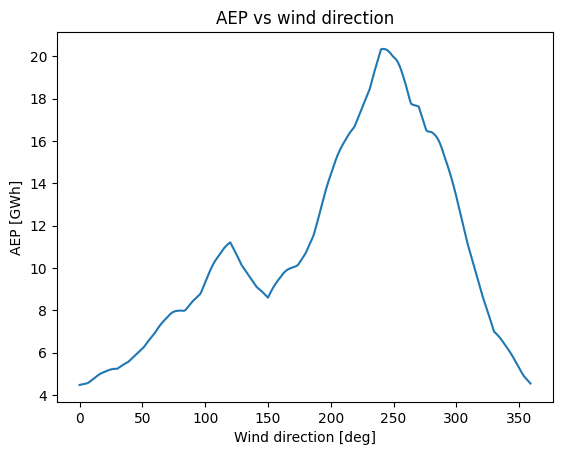

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
aep = simulationResult.aep() 
my_wt.plot(wt_x,wt_y)
c =plt.scatter(wt_x, wt_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')